In [2]:
import json
import pickle as cPickle
import numpy as np

from sklearn import svm
import sklearn.utils
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr


from collections import defaultdict
import math
from sklearn import preprocessing

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import spearmanr
from sklearn import linear_model
import re
import copy

import seaborn as sns
import pandas as pd
import scipy.stats
import statsmodels.stats.proportion
from sklearn.cross_validation import LeaveOneOut
from prediction_utils.show_examples import update, generate_snapshots, clean
from prediction_utils.features2vec import _get_term_features, _get_last_n_action_features, \
            _get_action_features, _get_repeatition_features, _get_balance_features, documents2feature_vectors

In [3]:
import matplotlib
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(int(100 * y))

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

In [14]:
COLOR = ["#bb5f4c",
"#8e5db0",
"#729b57"]

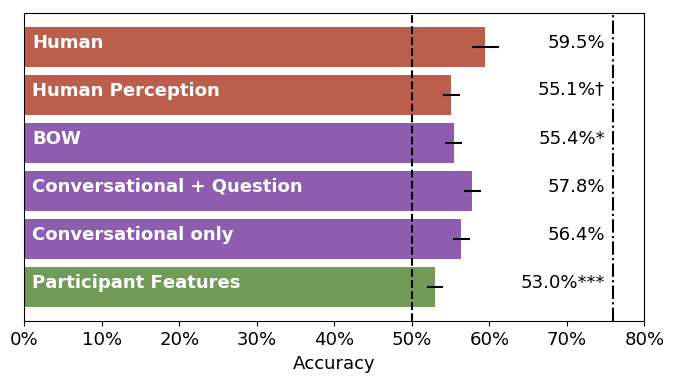

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 4))

# Example data
# conv+user C = 0.007
# BOW C= 0.00007
# Human 1 C = 0.0007
# FULL C = 0.0007
# User only C = 0.005
# conv only C = 0.005

methods = ('Human', 'Human Perception',  'BOW',   \
            'Conversational + Question', 'Conversational only', \
             'Participant Features')
y_pos = np.arange(len(methods))
performance = ( 0.595, 0.551, 0.554, 0.578, 0.564, 0.530)
err = [0.017,0.011, 0.011, 0.011, 0.011, 0.01]

barwidth = 0.5
gap = 0.1
ax.barh(y_pos * (barwidth + gap), performance, barwidth, xerr=err, align='center',
        color=[COLOR[c] for c in [0, 0, 1, 1, 1, 2]], ecolor='black')
ax.set_xlim(right=0.80)
upperbound = 0.759


fontsize=13
for i in range(len(methods)):
    text = '%.1f'%(performance[i]* 100) + '%'
    if methods[i] == 'Human Perception':
        text += '$\dag$'
    if methods[i] in ['BOW']:
        text += '*'
    if methods[i] == 'Participant Features':
        text += '***'
    ax.text( upperbound - 0.01, i * (barwidth+gap), text, fontsize=fontsize, horizontalalignment ='right')
    ax.text( 0.01, i * (barwidth+gap),methods[i], horizontalalignment ='left', fontsize=fontsize, fontweight='bold', color='white')
ax.set_yticks([])
#ax.set_yticklabels(methods)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy', fontsize=fontsize)
plt.axvline(x=0.5, color='k', linestyle='--')
plt.axvline(x=upperbound, color='k', linestyle='-.')
#plt.axhline(y=1.5, color='k', linestyle='-')
#plt.axhline(y=4.5, color='k', linestyle='-')
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(fontsize=fontsize)
plt.show()

In [ ]:
def plot_profiles1(profiles, ASPECTS, experience=-1):
    catergories = {'Min': 0, 'Max': 1, 'In the Middle': 2, 'Anonymous':3, 'New Comer':4, 'No Gap': 5, 'Bot': 6}
    cats = ['min', 'max', 'in the middle', 'Anonymous', 'New Comer']

    f, ax = plt.subplots(1, figsize=(13,6))
    bar_width = 0.4
    bar_l = [i for i in range(len(ASPECTS))] 
    tick_pos = [i+bar_width for i in bar_l]

    colors = ['pink', 'mediumslateblue', 'steelblue', 'mediumaquamarine', 'darksalmon']
    bads = [[[], [], [], [], [], [], []], [[], [], [], [], [], [], []]]
    total = len(profiles[0])
    alpha=[0.9, 0.3]
    conv_label = ['Offender is ', 'Non-offender is ']
    mins = [[], []]
    cnts = [[[], [], [], [], [], [], []], [[], [], [], [], [], [], []]]
    rects = []
    for clss in [0, 1]:
        for aspect in ASPECTS:
            cur = []
            for ind in range(len(catergories)):
                bads[clss][ind].append(0)
                cnts[clss][ind].append(0)
            for p in profiles[clss]:
            #    if not('experience') in p or p['experience'] <= experience:
            #        continue
                bads[clss][catergories[p[aspect]]][-1] += 1
                cnts[clss][catergories[p[aspect]]][-1] += 1
                if catergories[p[aspect]] == 0:
                    cur.append(1)
                elif catergories[p[aspect]] < 3:
                    cur.append(0)
            mins[clss].append(cur)
        previous = [0 for a in ASPECTS]
        first_three = [0 for a in ASPECTS]
        for bad in bads[clss][:3]:
            for ii, b in enumerate(bad):
                first_three[ii] += b
        for ind,bad in enumerate(bads[clss][:3]):
            for ii, b in enumerate(bad):
                if first_three[ii]: bad[ii] = bad[ii] / first_three[ii]
            bads[clss][ind] = bad
            rects = ax.bar(bar_l, bad, label=conv_label[clss] + cats[ind], bottom = previous, alpha=alpha[clss], \
                color=colors[ind],width=bar_width,edgecolor='white')
            for ind, rect in enumerate(rects):
                ax.text(rect.get_x() + rect.get_width()/2., (bad[ind] / 3 + previous[ind]),
                '%.1f' % (bad[ind]*100) + '%',
                ha='center', va='bottom')
            for ii, b in enumerate(bad):
                previous[ii] += b
      #  ax.legend(loc="upper center", bbox_to_anchor=(1,1), fontsize='large')
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0., fontsize='large')
        bar_l = [b+bar_width for b in bar_l]
        if clss:
            print('Good Total:')
        else:
            print('Bad Total:')
        for ii,aspect in enumerate(ASPECTS):
            print(aspect, first_three[ii])
    ax.set_ylabel("Percentage among All the Cases", fontsize='large')
  #  ax.set_xlabel("Aspect")
    Xticks = ['Proportion replied',\
              'Being replied latency', 'Reply latency', \
            'Age', 'Status', \
            '# edits on Wikipedia']
    plt.xticks([t - bar_width / 2 for t in tick_pos], Xticks, fontsize='large')
  #  ax.set_xlabel("")

    # rotate axis labels
    plt.setp(plt.gca().get_xticklabels(), rotation=20, horizontalalignment='right')
   # plt.title('Who\'s the Attacker')

    # shot plot
    plt.show()
  #  for aspect in ASPECTS:
  #      print(aspect, first_three[0], first_three[1])

    print('Test 1')
    for ind, aspect in enumerate(ASPECTS):
        print(aspect)
        print('Average in Ggap: ', np.mean(mins[1][ind]))
        print('Average of Bgap: ', np.mean(mins[0][ind]))
        if np.mean(mins[1][ind]) == 1 or np.mean(mins[1][ind]) == 0:
            continue
        print(scipy.stats.mannwhitneyu(mins[0][ind], mins[1][ind]))
        print('\n')
    print('Test 2')
    clss = 0
    for ind, aspect in enumerate(ASPECTS):
        print(aspect, ':', scipy.stats.binom_test(cnts[clss][0][ind], cnts[clss][0][ind] + cnts[clss][1][ind]))
     #   print(cnts[clss][0][ind], cnts[clss][1][ind])
    print('\n')
    print('Test 3')
    clss = 1
    for ind, aspect in enumerate(ASPECTS):
        print(aspect, ':', scipy.stats.binom_test(cnts[clss][0][ind], cnts[clss][0][ind] + cnts[clss][1][ind]))